<a href="https://colab.research.google.com/github/yrodriguezmd/Surgical_instruments/blob/main/Sets/Set_1/notebooks/Set_1_Model_A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Use COCO-pretrained VFNet to generate pseudolabels from Set_1

In [ ]:
!wget https://raw.githubusercontent.com/airctic/icevision/master/install_colab.sh
!bash install_colab.sh

In [2]:
exit()

In [ ]:
import icevision

In [2]:
from icevision.all import *
print('icevision v',icevision.__version__)
print('torch v',torch.__version__)
print('torchvision v',torchvision.__version__)

icevision v 0.10.0a1
torch v 1.9.0+cu111
torchvision v 0.10.0+cu111


Load annotated Set_1.  

In [3]:
! git clone https://github.com/yrodriguezmd/Surgical_instruments.git

Cloning into 'Surgical_instruments'...
remote: Enumerating objects: 1449, done.
remote: Counting objects: 100% (1449/1449), done.
remote: Compressing objects: 100% (1438/1438), done.
remote: Total 1449 (delta 212), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (1449/1449), 34.55 MiB | 17.48 MiB/s, done.
Resolving deltas: 100% (212/212), done.


In [28]:
# colab not showing files
# temporary way of uploading:
#from google.colab import drive
#drive.mount('/content/gdrive', force_remount = True)

Mounted at /content/gdrive


In [9]:
!ls Surgical_instruments/Sets/Set_1/annotated

README.dataset.txt  README.roboflow.txt  test  train  valid


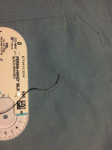

In [11]:
# visualize
# gdrive
#image_path = Path('gdrive/MyDrive/Surgical_instruments/Set_1.v1i.coco/train')
image_path = Path('Surgical_instruments/Sets/Set_1/annotated/train')

img_files = get_image_files(image_path)

img = PIL.Image.open(img_files[0]) ##
img = img.convert('RGB')

img.to_thumb(150,150)

In [12]:
# using project-specific classes
# 15 classes + background
classes = ['Towel_clip', 'Castroviejo', 'Yankauer', 'Hemostat', 'Army_navy', 'Richardson', 'Potts', 'Iris', 'Bulldog', 'Forceps', 'Scalpel', 'Frazier', 'Needle', 'Weitlaner', 'Mayo_metz']
class_map = ClassMap(classes)
len(class_map)

16

Parse data.

In [13]:
path = Path('Surgical_instruments/Sets/Set_1/annotated') # adjust if use git clone vs gdrive

train_parser = parsers.COCOBBoxParser(
    annotations_filepath = path/'train/_annotations.coco.json',
    img_dir = path/'train'
)

valid_parser = parsers.COCOBBoxParser(
    annotations_filepath = path/'valid/_annotations.coco.json',
    img_dir = path/'valid'
)

In [14]:
# dataset already split in annotation tool, maintain grouping

whole = SingleSplitSplitter()

train_records, *_ = train_parser.parse(data_splitter = whole)

valid_records, *_ = valid_parser.parse(data_splitter = whole)

  0%|          | 0/105 [00:00<?, ?it/s]

INFO     - Autofixing records | icevision.parsers.parser:parse:122


  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

INFO     - Autofixing records | icevision.parsers.parser:parse:122


  0%|          | 0/29 [00:00<?, ?it/s]

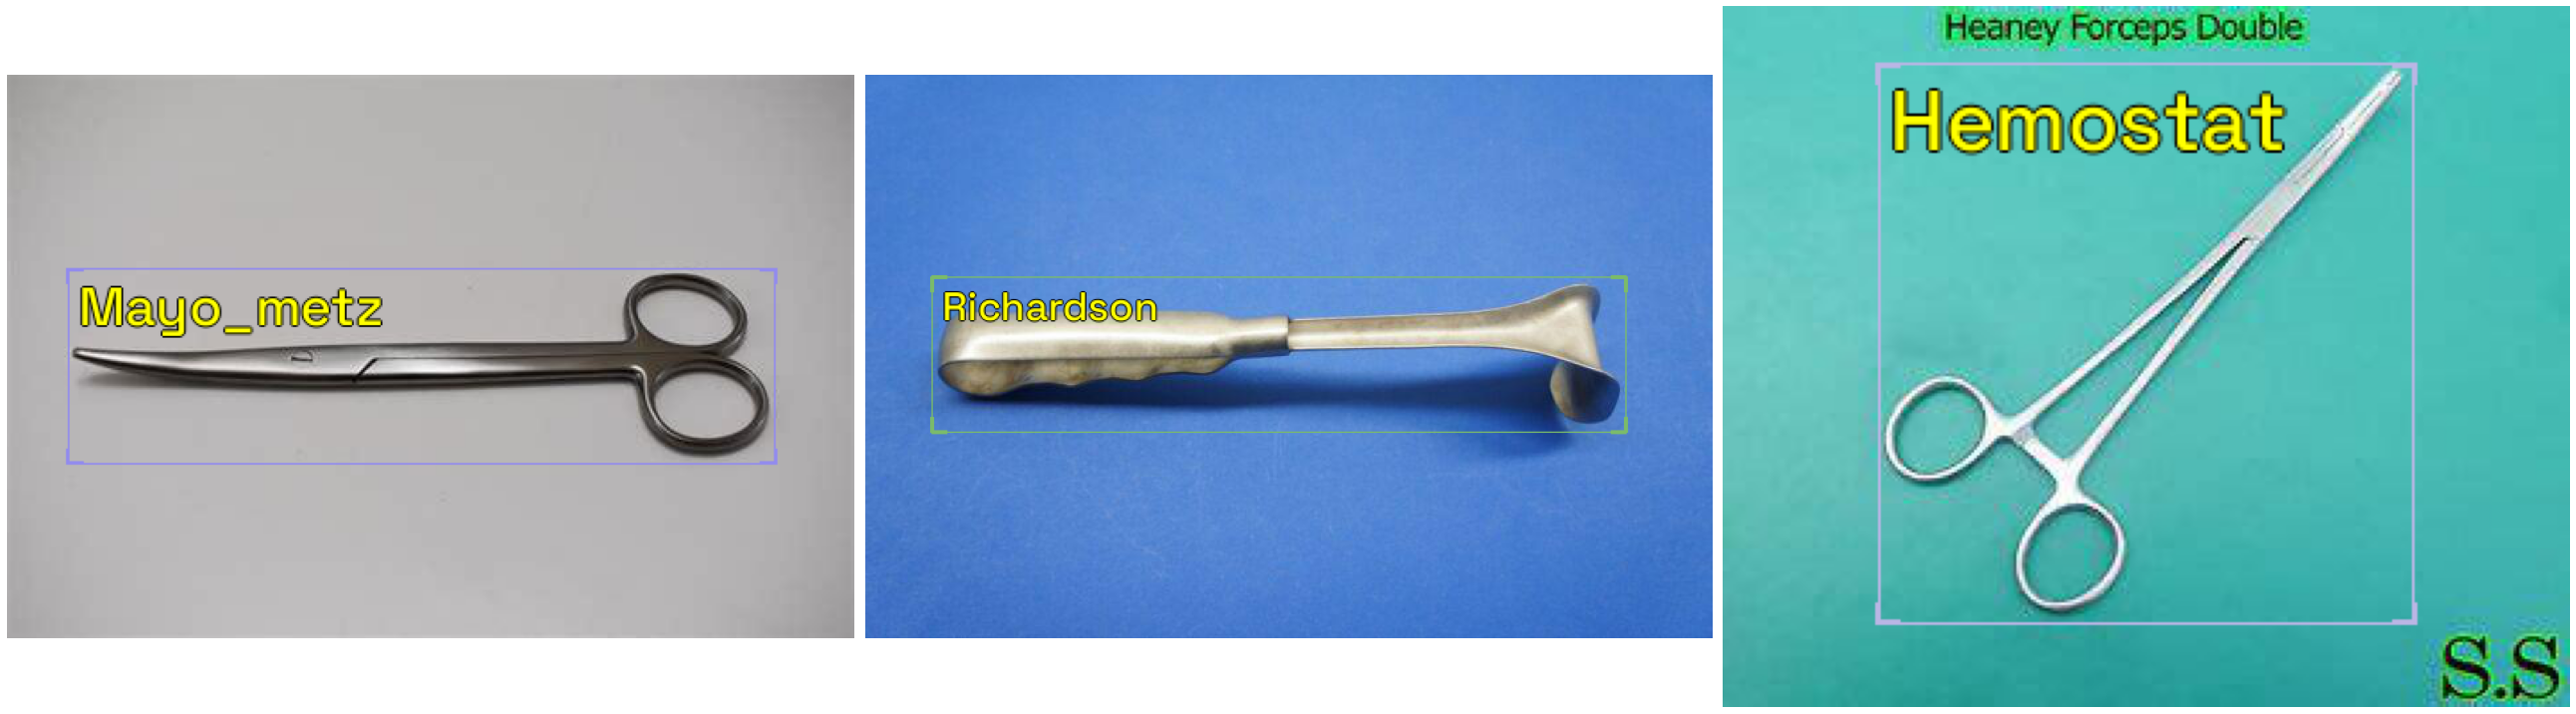

In [36]:
# visualize
show_records(train_records[0:3],ncols=3, font_size=30, label_color = '#ffff00')

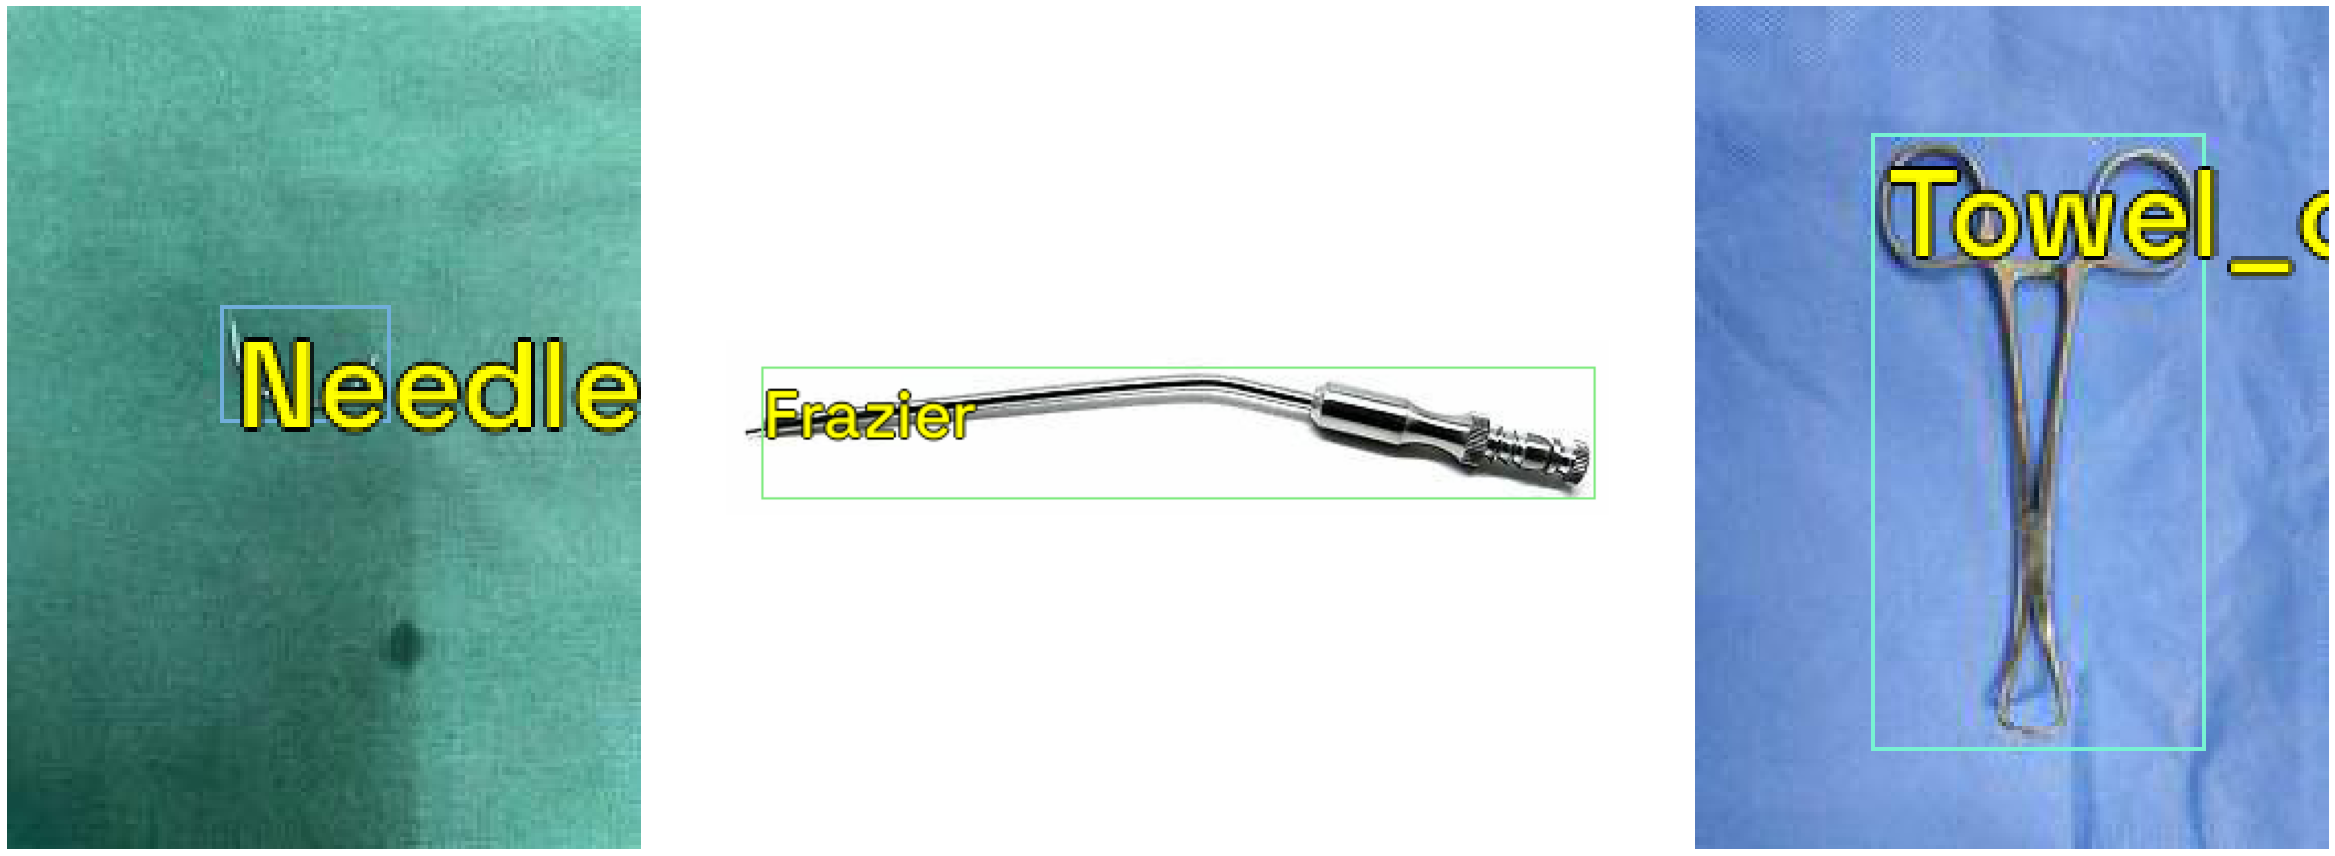

In [37]:
show_records(valid_records[0:3],ncols=3, font_size=30, label_color = '#ffff00')

Transforms and Dataset

In [15]:
presize = 512
image_size = 384

train_tfms = tfms.A.Adapter([*tfms.A.aug_tfms(size=presize), tfms.A.Normalize()])
valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(size=image_size), tfms.A.Normalize()])

In [16]:
train_ds = Dataset(train_records, train_tfms)
valid_ds = Dataset(valid_records, valid_tfms)

Train RetinaNet to generate teacher Model A.

In [17]:
metrics = [COCOMetric(metric_type=COCOMetricType.bbox)]

model_type = models.mmdet.retinanet ##
backbone = model_type.backbones.resnet50_fpn_1x ##

model = model_type.model(backbone=backbone(pretrained=True), num_classes=len(classes),)

  0%|          | 0/152149505 [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/builder.py:17: UserWarning: ``build_anchor_generator`` would be deprecated soon, please use ``build_prior_generator`` 
  '``build_anchor_generator`` would be deprecated soon, please use '
2021-10-14 22:46:49,522 - mmcv - INFO - initialize ResNet with init_cfg {'type': 'Pretrained', 'checkpoint': 'torchvision://resnet50'}
2021-10-14 22:46:49,524 - mmcv - INFO - load model from: torchvision://resnet50
2021-10-14 22:46:49,528 - mmcv - INFO - Use load_from_torchvision loader
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

2021-10-14 22:46:51,043 - mmcv - WARNING - The model and loaded state dict do not match exactly

unexpected key in source state_dict: fc.weight, fc.bias

2021-10-14 22:46:51,077 - mmcv - INFO - initialize FPN with init_cfg {'type': 'Xavier', 'layer': 'Conv2d', 'distribution': 'uniform'}
2021-10-14 22:46:51,135 - mmcv - INFO - initialize RetinaHead with init_cfg {'type': 'Normal', 'layer': 'Conv2d', 'std': 0.01, 'override': {'type': 'Normal', 'name': 'retina_cls', 'std': 0.01, 'bias_prob': 0.01}}
2021-10-14 22:46:51,177 - mmcv - INFO - 
backbone.conv1.weight - torch.Size([64, 3, 7, 7]): 
PretrainedInit: load from torchvision://resnet50 
 
2021-10-14 22:46:51,179 - mmcv - INFO - 
backbone.bn1.weight - torch.Size([64]): 
PretrainedInit: load from torchvision://resnet50 
 
2021-10-14 22:46:51,182 - mmcv - INFO - 
backbone.bn1.bias - torch.Size([64]): 
PretrainedInit: load from torchvision://resnet50 
 
2021-10-14 22:46:51,184 - mmcv - INFO - 
backbone.layer1.0.conv1.weight - torch.Size([64

Use load_from_local loader
The model and loaded state dict do not match exactly

size mismatch for bbox_head.retina_cls.weight: copying a param with shape torch.Size([720, 256, 3, 3]) from checkpoint, the shape in current model is torch.Size([126, 256, 3, 3]).
size mismatch for bbox_head.retina_cls.bias: copying a param with shape torch.Size([720]) from checkpoint, the shape in current model is torch.Size([126]).


In [18]:
train_dl = model_type.train_dl(train_ds, batch_size = 16, num_workers = 4,
                               shuffle=True)
valid_dl = model_type.valid_dl(valid_ds, batch_size=16, num_workers = 4,
                               shuffle=False)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [19]:
# use wandbd for training monitoring
from fastai.callback.wandb import *

wandb.init(project = 'Surgical_instruments', name = 'Set_1_Ret', reinit = True)

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [20]:
learn = model_type.fastai.learner(dls = [train_dl, valid_dl],
                                  model = model, metrics = metrics,
                                  cbs = WandbCallback())

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


SuggestedLRs(valley=7.585775892948732e-05)

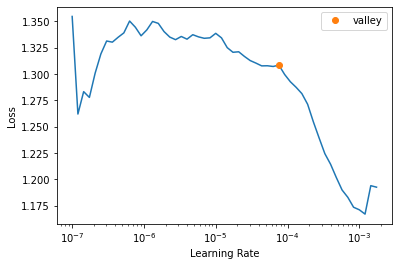

In [21]:
learn.lr_find() 

In [22]:
learn.fine_tune(30, 1e-4)

Could not gather input dimensions
WandbCallback requires use of "SaveModelCallback" to log best model
WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'Dataset' object has no attribute 'items'


epoch,train_loss,valid_loss,COCOMetric,time
0,1.299934,1.278392,0.007143,00:09


/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


Could not gather input dimensions


epoch,train_loss,valid_loss,COCOMetric,time
0,1.220480,1.236952,0.014286,00:08
1,1.194979,1.209453,0.038932,00:07
2,1.175149,1.187131,0.043749,00:06
3,1.138327,1.122556,0.077877,00:06
4,1.087372,1.033546,0.092163,00:07
5,1.026769,0.956322,0.081279,00:07
6,0.960768,0.914472,0.158715,00:07
7,0.898117,0.861924,0.088104,00:07
8,0.844032,0.846511,0.158622,00:07
9,0.797443,0.860393,0.152728,00:07


In [26]:
import matplotlib.pyplot as plt
def plot_metrics(learn, title):
  plt.plot(L(learn.recorder.values).itemgot())
  plt.xlabel('epoch')
  plt.ylabel('mAP (green), Loss (blue, orange)')
  plt.title(title)
  plt.text(0,-0.2, 
       'Legend: mAP(green), train_loss(blue), valid_loss(orange')
  plt.ylim(0,1);

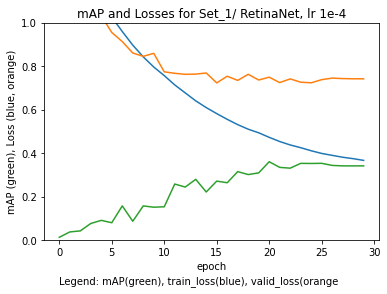

In [27]:
plot_metrics(learn, 'mAP and Losses for Set_1/ RetinaNet, lr 1e-4')

/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


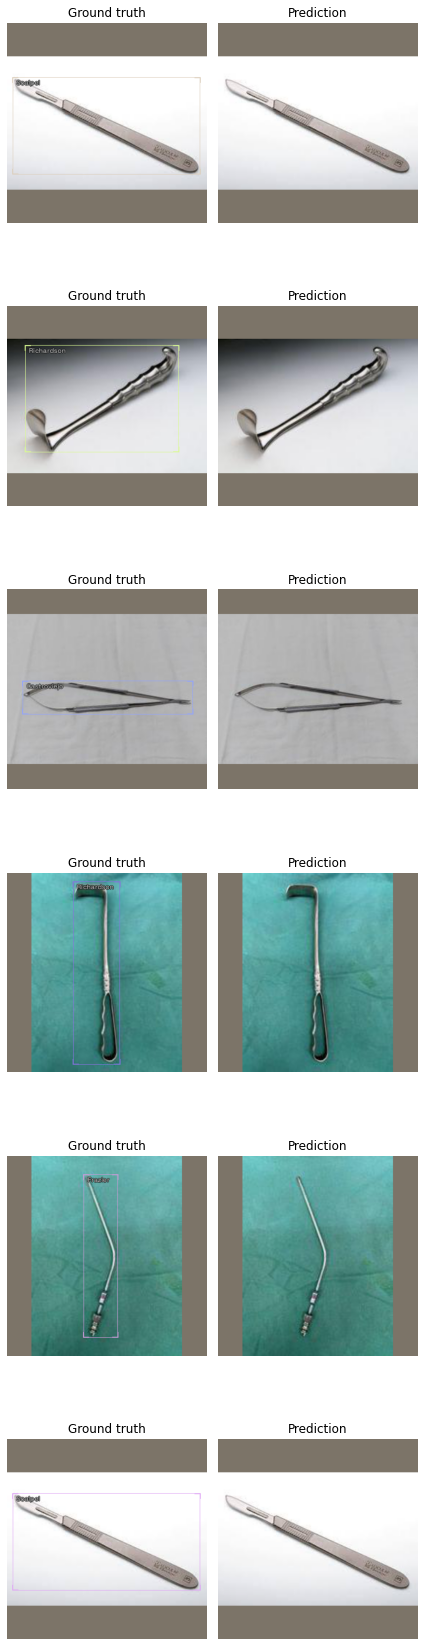

In [23]:
model_type.show_results(model, valid_ds)
# predictions not yet good even with valid ds

Save model as Model A.

In [30]:
from icevision.models import *

checkpoint_path = 'Model_A_ret_mAP34.pth'

save_icevision_checkpoint(model, 
                        model_name='mmdet.retinanet', 
                        backbone_name='resnet50_fpn_1x',
                        classes =  train_parser.class_map.get_classes(), 
                        img_size=image_size, 
                        filename=checkpoint_path,
                        meta={'icevision_version': '0.9.1'})

In [31]:
# temporary
from google.colab import files
files.download(checkpoint_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Store model for later iteration.

(Too big/ inappropriate file for github)

(Store in GDrive)